In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 
from DS_WCS_projections import *
import DS_Coma_Cluster_param as cc_prm
from DS_data_transformation import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from skimage.filters import gaussian
from skimage.draw import circle_perimeter

In [2]:
df = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_filtered.csv')
print(df.shape)
df.head()

(908997, 120)


,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS,phot_is_star_gaia
0,8000,483713,1944p275,0,DEV,194.370715,27.376434,7.766236e+10,5.132580e+10,0.010509,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,8000,483713,1944p275,1,PSF,194.375536,27.377389,6.551291e+10,5.075641e+10,0.010561,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4096,0
2,8000,483713,1944p275,3,REX,194.377318,27.377674,8.259466e+09,7.358640e+09,0.010576,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,8000,483713,1944p275,4,REX,194.368014,27.376374,1.218444e+10,1.040580e+10,0.010495,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,8000,483713,1944p275,5,PSF,194.376378,27.378784,1.483136e+09,1.303248e+09,0.010614,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [3]:
cc_prm.ra_center, cc_prm.dec_center

(194.9356, 28.0256)

In [4]:
sc = SkyCoord(ra=np.array(df['RA'])*u.degree, 
              dec=np.array(df['DEC'])*u.degree, frame='icrs')
sc_cen = SkyCoord(ra=cc_prm.ra_center*u.degree, 
                 dec=cc_prm.dec_center*u.degree, frame='icrs')
in_rad = sc.separation(sc_cen).degree < cc_prm.radius
np.count_nonzero(in_rad)

259970

In [5]:
df = df[in_rad]
df.index = np.arange(df.shape[0])

In [6]:
df_brighest = n_max_flux_df(df, 100, ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

In [7]:
c_wcs = custom_wcs(cc_prm.ra_center, cc_prm.dec_center)
print(c_wcs.array_shape)
dist_from_center(c_wcs)

(2048, 2048)


/home/rt2122/L/git/data-segmentation-2/modules/DS_WCS_projections.py:39: RuntimeWarning: cdelt will be ignored since cd is present
  w1.wcs.cdelt = w.wcs.cdelt[:2]


1.1376284753016908

In [9]:
cur_pixels = c_wcs.all_world2pix(df_brighest['RA'], 
                                 df_brighest['DEC'], 0)
cur_pixels = np.array(cur_pixels, dtype=np.int32).T
cur_pixels.shape

(100, 2)

In [12]:
pic_g = draw_circles(cur_pixels, np.array(df_brighest['FLUX_G']), (2048, 2048, 1), 0.01)

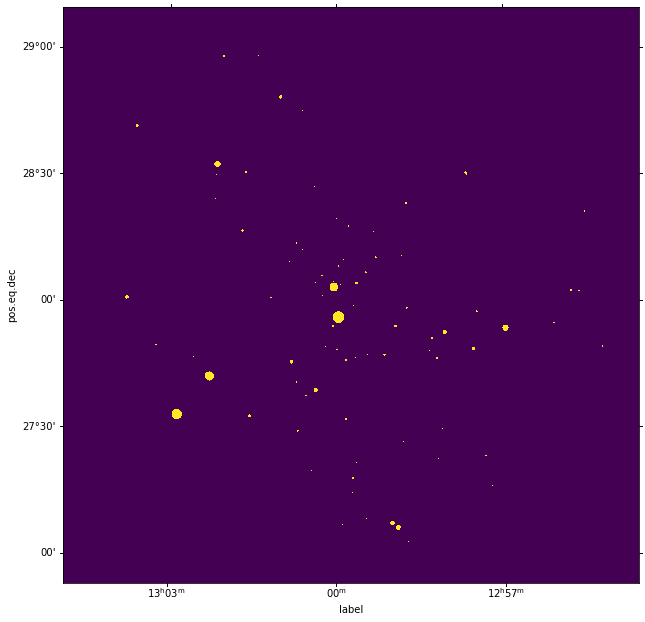

In [13]:
show_pic(pic_g[:,:,0], projection=c_wcs)

In [14]:
pic_grz = np.zeros((2048, 2048, 3))
for num_ch, ch in enumerate(['FLUX_G', 'FLUX_R', 'FLUX_Z']):
    df_brightest = n_max_flux_df(df, 20, ch)
    pixels = c_wcs.all_world2pix(df_brightest['RA'], df_brightest['DEC'], 0)
    pixels = np.array(pixels, dtype=np.int32).T
    pic_grz[:,:,num_ch] = draw_circles(pixels, np.array(df_brightest[ch]), 
                                       (2048, 2048), 0.03)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


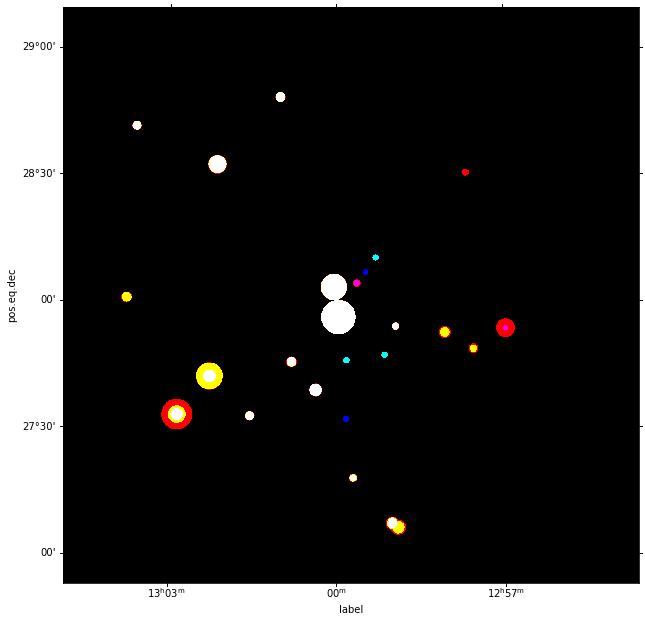

In [15]:
show_pic(pic_grz, projection=c_wcs)

In [16]:
r500_pix = find_radius_wcs(cc_prm.r500, c_wcs)

In [17]:
circle_r500 = circle_perimeter(1024, 1024, r500_pix, shape=(2048, 2048, 3))

In [18]:
pic_grz[circle_r500] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


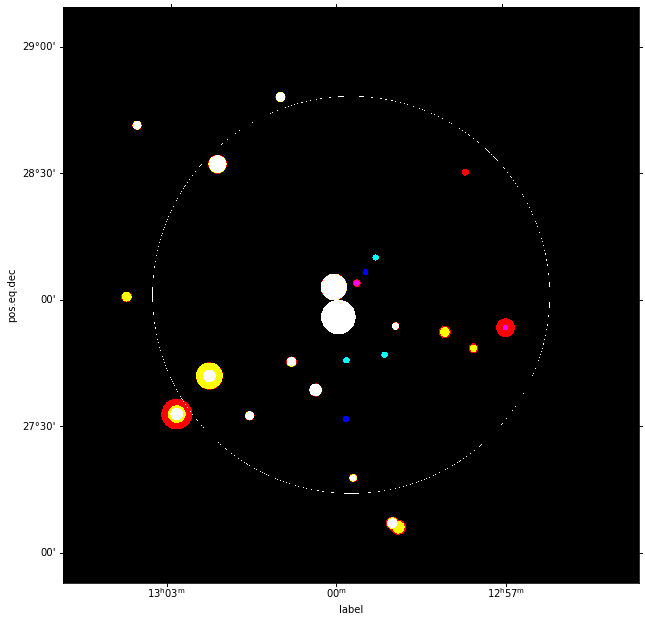

In [19]:
show_pic(pic_grz, projection=c_wcs)

In [33]:
pic_g_2 = np.zeros((2048, 2048, 3))
flux_list = ['FLUX_G', 'FLUX_R', 'FLUX_Z']
for num_ch, ch in enumerate(flux_list):
    df_brightest = n_max_flux_df(df, 20, [ch, flux_list[(num_ch + 1) % 3]])
    pixels = c_wcs.all_world2pix(df_brightest['RA'], df_brightest['DEC'], 0)
    pixels = np.array(pixels, dtype=np.int32).T
    pic_g_2[:,:,num_ch] = draw_circles(pixels, np.array(df_brightest['FLUX_G']), 
                                       (2048, 2048), 0.03)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


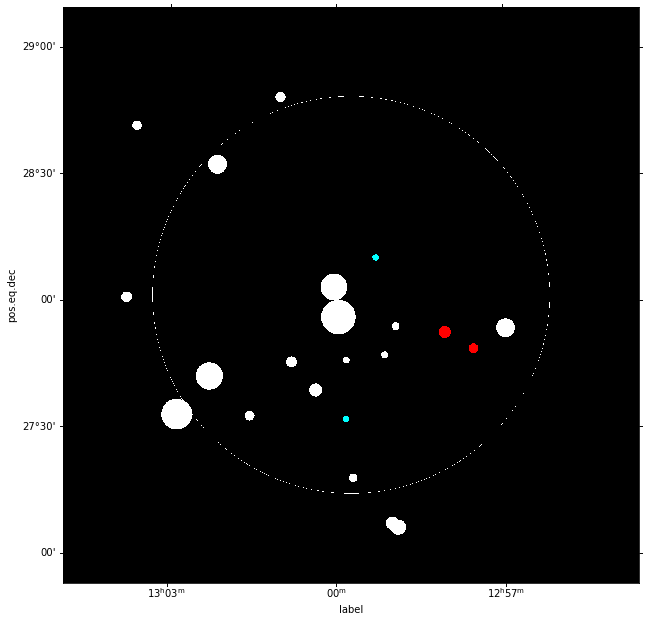

In [36]:
pic_g_2[circle_r500] = 1
show_pic(pic_g_2, projection=c_wcs)

In [37]:
pic_grz_3 = np.zeros((2048, 2048, 3))
flux_list = ['FLUX_G', 'FLUX_R', 'FLUX_Z']
for num_ch, ch in enumerate(flux_list):
    df_brightest = n_max_flux_df(df, 20, flux_list)
    pixels = c_wcs.all_world2pix(df_brightest['RA'], df_brightest['DEC'], 0)
    pixels = np.array(pixels, dtype=np.int32).T
    pic_grz_3[:,:,num_ch] = draw_circles(pixels, np.array(df_brightest[ch]), 
                                       (2048, 2048), 0.03)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


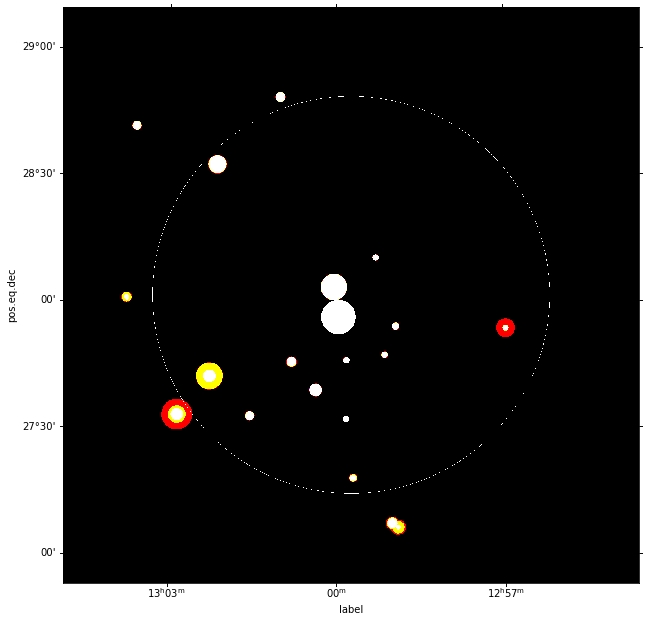

In [38]:
pic_grz_3[circle_r500] = 1
show_pic(pic_grz_3, projection=c_wcs)